In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

import logging
from typing import TypedDict, List

import pandas as pd
# import folium

# LangChain / LLM / Embedding
from langchain.schema import Document
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field

# Pinecone / LangChain-Pinecone
import pinecone
from langchain_pinecone import PineconeVectorStore

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver



c:\Users\Sreemoyi\Desktop\SIH-INGRES\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Sreemoyi\Desktop\SIH-INGRES\venv\Lib\site-packages\langchain_pinecone\__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_pinecone.vectorstores import Pinecone, PineconeVectorStore


In [4]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", api_key=os.getenv("GEMINI_API_KEY"))
embedding_function = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=os.getenv("GEMINI_API_KEY"))
chat_for_classify = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=os.getenv("GEMINI_API_KEY")
    )

In [ ]:
# import pandas as pd
# import os
# import gc
# import time
# import logging
# from dotenv import load_dotenv

# from pinecone import Pinecone, ServerlessSpec
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_pinecone import PineconeVectorStore
# from langchain_google_genai import GoogleGenerativeAIEmbeddings

# # ---------------------------
# # Logging setup
# # ---------------------------
# logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# # ---------------------------
# # Load environment variables
# # ---------------------------
# load_dotenv()
# PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
# PINECONE_INDEX_NAME = os.getenv("PINECONE_INDEX", "ingres-index")

# if not PINECONE_API_KEY:
#     raise RuntimeError("Please set PINECONE_API_KEY in your environment or .env file")

# # ---------------------------
# # 1. Load Data from CSVs
# # ---------------------------
# try:
#     df1 = pd.read_csv("data/dwlr_realtime_data.csv")
#     df2 = pd.read_csv("data/groundwater_quality_data.csv")
#     df3 = pd.read_csv("data/groundwater_trends_2015_2023.csv")
#     df4 = pd.read_csv("data/ingres_assessment_units_2023.csv")
#     logging.info("Successfully loaded CSV files.")
# except FileNotFoundError as e:
#     logging.error(f"Error loading CSV file: {e}. Please ensure 'data/' folder exists with CSV files.")
#     exit()

# # ---------------------------
# # 2. Convert DataFrames → Text Documents
# # ---------------------------
# def df_to_text(df, name):
#     docs = []
#     for _, row in df.iterrows():
#         text = f"{name} Record: " + " | ".join([f"{col}: {row[col]}" for col in df.columns if pd.notna(row[col])])
#         docs.append(text)
#     return docs

# docs1 = df_to_text(df1, "Realtime")
# docs2 = df_to_text(df2, "Quality")
# docs3 = df_to_text(df3, "Trend")
# docs4 = df_to_text(df4, "Assessment")
# all_docs = docs1 + docs2 + docs3 + docs4
# gc.collect()

# # ---------------------------
# # 3. Chunk Documents
# # ---------------------------
# logging.info("Chunking documents...")
# splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
# documents = splitter.create_documents(all_docs)
# logging.info(f"Created {len(documents)} chunks.")

# # ---------------------------
# # 4. Initialize Embeddings
# # ---------------------------
# GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
# if not GEMINI_API_KEY:
#     raise RuntimeError("Please set GEMINI_API_KEY in your environment or .env file")

# embedding_function = GoogleGenerativeAIEmbeddings(
#     model="models/embedding-001", 
#     google_api_key=GEMINI_API_KEY
# )

# # Test embedding to get dimension
# test_vector = embedding_function.embed_query("hello world")
# DIMENSION = len(test_vector)
# logging.info(f"Embedding dimension: {DIMENSION}")

# # ---------------------------
# # 5. Initialize Pinecone client
# # ---------------------------
# pc = Pinecone(api_key=PINECONE_API_KEY)

# # Get existing indexes
# existing_indexes = [idx.name for idx in pc.list_indexes()]

# if PINECONE_INDEX_NAME not in existing_indexes:
#     logging.info(f"Creating Pinecone index '{PINECONE_INDEX_NAME}' with dim={DIMENSION}...")
#     pc.create_index(
#         name=PINECONE_INDEX_NAME,
#         dimension=DIMENSION,
#         metric="cosine",
#         spec=ServerlessSpec(cloud="aws", region="us-east-1")
#     )
#     # Wait for index to be ready
#     while True:
#         idx_list = pc.list_indexes()
#         if any(idx.name == PINECONE_INDEX_NAME for idx in idx_list):
#             break
#         logging.info("Waiting for index to be ready...")
#         time.sleep(2)
#     logging.info(f"Index '{PINECONE_INDEX_NAME}' is ready.")
# else:
#     logging.info(f"Index '{PINECONE_INDEX_NAME}' already exists. Connecting...")

# # ---------------------------
# # 6. Create VectorStore & Upsert
# # ---------------------------
# logging.info("Upserting documents into Pinecone...")
# vectorstore = PineconeVectorStore.from_documents(
#     documents=documents,
#     embedding=embedding_function,
#     index_name=PINECONE_INDEX_NAME
# )
# logging.info("Documents successfully upserted.")

# # ---------------------------
# # 7. Create Retriever
# # ---------------------------
# retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 4})
# logging.info("Retriever is ready.")

# print("\n--- Process Complete ---")
# print(f"Pinecone index '{PINECONE_INDEX_NAME}' contains your embeddings.")
# print("The 'retriever' object is ready for use in your RAG pipeline.")


2025-09-06 23:32:38,333 - INFO - Successfully loaded CSV files.


2025-09-06 23:32:38,762 - INFO - Chunking documents...
2025-09-06 23:32:38,912 - INFO - Created 2699 chunks.
2025-09-06 23:32:40,754 - INFO - Embedding dimension: 768
2025-09-06 23:32:42,416 - INFO - Index 'sih2' already exists. Connecting...
2025-09-06 23:32:42,419 - INFO - Upserting documents into Pinecone...
2025-09-06 23:34:29,091 - INFO - Documents successfully upserted.
2025-09-06 23:34:29,152 - INFO - Retriever is ready.



--- Process Complete ---
Pinecone index 'sih2' contains your embeddings.
The 'retriever' object is ready for use in your RAG pipeline.


In [59]:
# ---------------------------
# Logging setup
# ---------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ---------------------------
# Load environment variables
# ---------------------------
load_dotenv()
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_INDEX_NAME = os.getenv("PINECONE_INDEX", "ingres-index")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

if not PINECONE_API_KEY or not GEMINI_API_KEY:
    raise RuntimeError("Please set PINECONE_API_KEY and GEMINI_API_KEY in your environment or .env file.")

# ---------------------------
# 1. Load Data from CSVs
# ---------------------------
try:
    df_rt = pd.read_csv("data/dwlr_realtime_data.csv")
    df_qual = pd.read_csv("data/groundwater_quality_data.csv")
    df_trend = pd.read_csv("data/groundwater_trends_2015_2023.csv")
    df_assess = pd.read_csv("data/ingres_assessment_units_2023.csv")
    logging.info("Successfully loaded CSV files.")
except FileNotFoundError as e:
    logging.error(f"Error loading CSV file: {e}. Please ensure 'data/' folder exists with CSV files.")
    exit()

# ---------------------------
# 2. Convert DataFrames → Documents with rich metadata
# ---------------------------
import pandas as pd
from langchain_core.documents import Document


def df_to_documents(df, name):
    """
    Converts a pandas DataFrame into a list of LangChain Document objects.
    Each row is converted to a descriptive text with all original data as metadata.

    Args:
        df (pd.DataFrame): The input DataFrame.
        name (str): A name for the dataset, used to determine the narrative text.
    
    Returns:
        list[Document]: A list of Document objects.
    """
    docs = []
    for _, row in df.iterrows():
        # Create a more narrative, descriptive text for better embeddings
        if name == "Assessment":
            text = (
                f"This is an assessment record for the groundwater resources in the {row['Block_Name']} block, {row['District']} district, in the state of {row['State']}. "
                f"The assessment year is {row['Assessment_Year']}. The stage of groundwater extraction is a key indicator and is recorded as {row['Stage_of_Extraction_Percent']}%, which is categorized as {row['Category']}. "
                f"The annual recharge is {row['Annual_Recharge_MCM']} MCM, and the population of the area is {row['Population']}."
            )
        elif name == "Quality":
            text = (
                f"This is a {name} record for a well in the {row['District']} district in the state of {row['State']}. "
                f"The sample was taken on {row['Sample_Date']}. The water's pH is {row['pH_pH_units']} and its Total Dissolved Solids (TDS) is {row['TDS_mg_L']} mg/L. "
                f"Hardness is {row['Hardness_mg_L_as_CaCO3']} mg/L, Chloride is {row['Chloride_mg_L']} mg/L, and Iron is {row['Iron_mg_L']} mg/L. "
                f"The well is a {row['Well_Type']} type with a depth of {row['Well_Depth_M']} meters."
            )
        elif name == "Trends":
            text = (
                f"This is a groundwater trend record for the {row['District']} district in {row['State']} for the year {row['Year']}. "
                f"This data tracks key trends including the stage of extraction, which was {row['Stage_of_Extraction_Percent']}%. "
                f"The annual recharge was {row['Annual_Recharge_BCM']} billion cubic meters (BCM) and the annual extraction was {row['Annual_Extraction_BCM']} BCM. "
                f"The average water level was {row['Average_Water_Level_MBGL']} meters below ground level (MBGL), "
                f"and there were {row['Over_Exploited_Units']} over-exploited units and {row['Critical_Units']} critical units."
            )
        elif name == "Realtime":
            text = (
                f"This is a real-time data record from station {row['Station_ID']} in {row['State']}. "
                f"The timestamp is {row['Timestamp']}. The current water level is {row['Water_Level_MBGL']} meters below ground level (MBGL), "
                f"and the water temperature is {row['Temperature_C']}°C. "
                f"The data quality is reported as {row['Data_Quality']}."
            )
        else:
            text = f"{name} Record: " + " | ".join([f"{col}: {row[col]}" for col in df.columns if pd.notna(row[col])])
        
        docs.append(Document(page_content=text, metadata=row.to_dict()))
    return docs

documents = []
documents.extend(df_to_documents(df_rt, "Realtime"))
documents.extend(df_to_documents(df_qual, "Quality"))
documents.extend(df_to_documents(df_trend, "Trend"))
documents.extend(df_to_documents(df_assess, "Assessment"))
gc.collect()

logging.info(f"Created {len(documents)} total documents from dataframes.")

# ---------------------------
# 3. Initialize Embeddings and Pinecone
# ---------------------------
embedding_function = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001", 
    google_api_key=GEMINI_API_KEY
)

test_vector = embedding_function.embed_query("hello world")
DIMENSION = len(test_vector)
logging.info(f"Embedding dimension: {DIMENSION}")

pc = Pinecone(api_key=PINECONE_API_KEY)
existing_indexes = [idx.name for idx in pc.list_indexes()]

if PINECONE_INDEX_NAME not in existing_indexes:
    logging.info(f"Creating Pinecone index '{PINECONE_INDEX_NAME}' with dim={DIMENSION}...")
    pc.create_index(
        name=PINECONE_INDEX_NAME,
        dimension=DIMENSION,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
    while True:
        idx_list = pc.list_indexes()
        if any(idx.name == PINECONE_INDEX_NAME for idx in idx_list):
            break
        logging.info("Waiting for index to be ready...")
        time.sleep(2)
    logging.info(f"Index '{PINECONE_INDEX_NAME}' is ready.")
else:
    logging.info(f"Index '{PINECONE_INDEX_NAME}' already exists. Connecting...")

# ---------------------------
# 4. Create VectorStore & Upsert
# ---------------------------
logging.info("Upserting documents into Pinecone...")
# PineconeVectorStore handles the embedding and upserting automatically
vectorstore = PineconeVectorStore.from_documents(
    documents=documents,
    embedding=embedding_function,
    index_name=PINECONE_INDEX_NAME
)
logging.info("Documents successfully upserted.")

# ---------------------------
# 5. Create Retriever
# ---------------------------
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 5})
logging.info("Retriever is ready.")

print("\n--- Process Complete ---")
print(f"Pinecone index '{PINECONE_INDEX_NAME}' contains your embeddings.")
print("The 'retriever' object is ready for use in your RAG pipeline.")

2025-09-07 01:48:35,352 - INFO - Successfully loaded CSV files.


2025-09-07 01:48:36,067 - INFO - Created 2599 total documents from dataframes.
2025-09-07 01:48:38,018 - INFO - Embedding dimension: 768
2025-09-07 01:48:39,314 - INFO - Index 'sih2' already exists. Connecting...
2025-09-07 01:48:39,317 - INFO - Upserting documents into Pinecone...
2025-09-07 01:50:08,151 - INFO - Documents successfully upserted.
2025-09-07 01:50:08,156 - INFO - Retriever is ready.



--- Process Complete ---
Pinecone index 'sih2' contains your embeddings.
The 'retriever' object is ready for use in your RAG pipeline.


In [50]:
import os
import pandas as pd
from dotenv import load_dotenv
from pinecone import Pinecone, ServerlessSpec
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# -----------------------------
# Load API keys
# -----------------------------
load_dotenv()
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

# -----------------------------
# Setup embeddings
# -----------------------------
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    google_api_key=GEMINI_API_KEY
)

# -----------------------------
# Setup Pinecone
# -----------------------------
pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "groundwater-index"

# Create index if not exists
if index_name not in [i.name for i in pc.list_indexes()]:
    pc.create_index(
        name=index_name,
        dimension=768,  # Gemini embedding dimension
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)

# -----------------------------
# Load CSVs and prepare text
# -----------------------------
folder = "data"
files = [
    "dwlr_realtime_data.csv",
    "groundwater_quality_data.csv",
    "groundwater_trends_2015_2023.csv",
    "ingres_assessment_units_2023.csv"
]

all_texts = []
for file in files:
    df = pd.read_csv(os.path.join(folder, file))
    for i, row in df.iterrows():
        text = " | ".join([f"{col}: {row[col]}" for col in df.columns])
        all_texts.append((f"{file}_{i}", text, {"source": file}))

# -----------------------------
# Generate embeddings & upsert
# -----------------------------
vectors = []
for _id, text, meta in all_texts:
    vector = embeddings.embed_query(text)
    vectors.append((_id, vector, meta))

# Batch insert (Pinecone prefers batches)
index.upsert(vectors[:100])  # you can loop in chunks if too large

print(f"Inserted {len(vectors)} vectors into Pinecone!")


KeyboardInterrupt: 

In [60]:
class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage
    needs_gis: bool
    gis_data: dict
    map_html: str

In [74]:
class GradeQuestion(BaseModel):
    score: str = Field(description='Is user asking INGRES data? Yes/No')

class GISRequest(BaseModel):
    needs_gis: str = Field(description='Need GIS map? Yes/No')
    location_data: str = Field(description='Extracted location info')
class GradeDocument(BaseModel):
    """Binary score to grade the document's relevance to the question."""
    score: str = Field(description="Relevance score, must be either 'Yes' or 'No'.")
# class GradeDocument(BaseModel):
#     score: str = Field(description='Relevant? Yes/No')

In [75]:
import logging
import folium
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# Setup logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


In [112]:
def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=os.getenv("GEMINI_API_KEY"))
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state


In [113]:
def question_classifier(state: AgentState):
    print("Entering question_classifier")
    system_message = SystemMessage(
        content="""You are a classifier that determines whether a user's question is about one of the following topics, based on the provided context:
        
        1. Groundwater quality (e.g., pH, TDS, hardness, fluoride, nitrate, iron, arsenic)
        2. Groundwater extraction stages and trends
        3. Well water levels and depth
        4. Annual recharge and extraction rates
        5. Specific assessment units, blocks, or districts
        6. Real-time station data (e.g., water level, temperature)
        7. Any other topic directly related to the INGRES groundwater database.
        
        If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.
        """
    )

    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    api_key=os.getenv("GEMINI_API_KEY"))
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

In [114]:
def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"

In [115]:
def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state


In [116]:
def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    api_key=os.getenv("GEMINI_API_KEY"))
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

In [117]:

def retrieval_grader(state: AgentState):
    """
    Grades retrieved documents based on their relevance to a user's question.
    Adds a de-duplication step for more reliable grading.

    Args:
        state (AgentState): The current state of the agent, containing the
                            rephrased question and a list of documents.

    Returns:
        AgentState: The updated state with only the relevant documents and
                    a flag indicating whether to proceed.
    """
    print("Entering retrieval_grader")

    # --- NEW: De-duplication step ---
    # Use a set to store unique document page contents to remove duplicates.
    unique_documents_content: Set[str] = set()
    deduplicated_docs: List[object] = []
    for doc in state["documents"]:
        if doc.page_content not in unique_documents_content:
            unique_documents_content.add(doc.page_content)
            deduplicated_docs.append(doc)
    
    # Use the de-duplicated list for grading.
    documents_to_grade = deduplicated_docs

    api_key = os.getenv("GEMINI_API_KEY")
    if not api_key:
        raise ValueError("GEMINI_API_KEY environment variable not set.")

    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        api_key=api_key
    )
    
    structured_llm = llm.with_structured_output(GradeDocument)

    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No' as your score.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    relevant_docs = []
    
    for doc in documents_to_grade:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        
        grader_llm = grade_prompt | structured_llm
        
        try:
            result = grader_llm.invoke({})
            grade_score = result.score.strip().lower()
            
            print(f"Grading document: {doc.page_content[:30]}... Result: {grade_score}")

            if grade_score == "yes":
                relevant_docs.append(doc)
        except Exception as e:
            print(f"Error grading document: {doc.page_content[:30]}... - Error: {e}")

    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    
    return state


In [118]:
def proceed_router(state: AgentState):
    if state.get('proceed_to_generate'):
        return 'generate_answer'
    return 'cannot_answer' if state.get('rephrase_count',0) >= 2 else 'refine_question'

def refine_question(state: AgentState):
    if state.get('rephrase_count',0) >= 2:
        return state
    msgs = [SystemMessage(content='Refine INGRES query slightly'), HumanMessage(content=state['rephrased_question'])]
    try:
        new_q = ChatGoogleGenerativeAI(model="gemini-2.5-flash", api_key=os.getenv("GEMINI_API_KEY")).invoke(ChatPromptTemplate.from_messages(msgs).format()).content.strip()
    except Exception:
        new_q = state['rephrased_question'] + ' (please be more specific)'
    state['rephrased_question'] = new_q
    state['rephrase_count'] = state.get('rephrase_count',0) + 1
    return state

In [135]:
# def generate(state: AgentState): 
#     print("Entering generation node.")

#     if not state["documents"]:
#         state["generated_answer"] = "I cannot find the information you're looking for. Please try a different query."
#         return state

#     context = "\n\n".join([doc.page_content for doc in state["documents"]])

#     llm = ChatGoogleGenerativeAI(
#         model="gemini-1.5-flash-latest",
#         api_key=os.getenv("GEMINI_API_KEY"),
#         temperature=0.0
#     )

#     system_message = SystemMessage(
#         content=f"""You are a helpful assistant. 
# Use the following context to answer the user's question about groundwater.

# The user may ask about a district, but the context may contain:
# - block-level data within that district
# - trend records by year for that district

# You must treat both block-level and trend-level as valid answers for the district.



# If truly nothing is relevant, only then say you cannot find the information.

# Context:
# {context}
# """
#     )

#     human_message = HumanMessage(
#         content=f"User question: {state['rephrased_question']}"
#     )

#     try:
#         result = llm.invoke([system_message, human_message])
#         state["generated_answer"] = result.content
#         print(f"Generated Content: {state['generated_answer']}")
#     except Exception as e:
#         print(f"Error during answer generation: {e}")
#         state["generated_answer"] = "An error occurred while generating the answer."

#     return state
def generate(state: AgentState): 
    print("Entering generation node.")

    if not state["documents"]:
        state["generated_answer"] = "I cannot find the information you're looking for. Please try a different query."
        return state

    # Join all retrieved docs
    context = "\n\n".join([doc.page_content for doc in state["documents"]])

    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        api_key=os.getenv("GEMINI_API_KEY"),
        temperature=0.0
    )

    # Put rules in system
    system_message = SystemMessage(
        content="""You are a helpful assistant.The context you receive obviously contains detailed groundwater data at various levels (block-level, district-level, yearly trends). 
Use the provided context to answer the user's groundwater-related question. 
If context has block-level data and the user asked district-level, treat block-level as valid.
If context has yearly trend data, treat that as valid too.
Never say you cannot find the information as you are getting all the information.
The user may make spelling mistakes - do your best to interpret.
Answer concisely."""
    )

    # Put both context + question in the human message
    human_message = HumanMessage(
        content=f"""Context:
{context}

User question: {state['rephrased_question']}

Answer:"""
    )

    try:
        result = llm.invoke([system_message, human_message])
        state["generated_answer"] = result.content
        print(f"Generated Content: {state['generated_answer']}")
    except Exception as e:
        print(f"Error during answer generation: {e}")
        state["generated_answer"] = "An error occurred while generating the answer."

    return state


In [136]:


logger = logging.getLogger(__name__)


def gis_classifier(state: AgentState):
    last = state['messages'][-1].content if state.get('messages') else ''
    msgs = [SystemMessage(content='Need GIS map? Yes/No'), HumanMessage(content=f"{state['rephrased_question']}\n\n{last}")]
    try:
        r = ChatGoogleGenerativeAI(model="gemini-2.5-flash", api_key=os.getenv("GEMINI_API_KEY")).with_structured_output(GISRequest).invoke(ChatPromptTemplate.from_messages(msgs).format())
        state['needs_gis'] = r.needs_gis.strip().lower() == 'yes'
        state['gis_data'] = {'location': r.location_data.strip()} if state['needs_gis'] else {}
    except Exception:
        q = (state.get('rephrased_question','') + ' ' + last).lower()
        state['needs_gis'] = any(w in q for w in ['map','location','district','lat','lon','show me','plot'])
        state['gis_data'] = {'location': state.get('rephrased_question','')} if state['needs_gis'] else {}
    return state

def generate_gis_map(state: AgentState):
    if not state.get('needs_gis'):
        return state
    pts = [
        {"lat":15.3, "lon":75.7, "val":200},
        {"lat":19.0, "lon":77.0, "val":250}
    ]
    m = folium.Map(location=[22,79], zoom_start=5)
    for p in pts:
        folium.CircleMarker([p['lat'], p['lon']], radius=5 + p['val']*0.01, popup=str(p['val'])).add_to(m)
    state['map_html'] = m._repr_html_()
    last = state['messages'][-1]
    state['messages'][-1] = AIMessage(content=last.content + '\n\n[GIS Map Attached]')
    return state

def cannot_answer(state: AgentState):
    state.setdefault('messages',[]).append(AIMessage(content="I'm sorry, I can't find that."))
    return state

def off_topic_response(state: AgentState):
    state.setdefault('messages',[]).append(AIMessage(content="I'm sorry, I cannot answer this."))
    return state

# ---------------------------
# Build LangGraph workflow
# ---------------------------
cp = MemorySaver()
wf = StateGraph(AgentState)

nodes = [
    'question_rewriter','question_classifier','off_topic_response',
    'retrieve','retrieval_grader','generate_answer',
    'refine_question','cannot_answer',
    'gis_classifier','generate_gis_map'
]
for n in nodes:
    wf.add_node(n, globals()[n])

wf.set_entry_point('question_rewriter')
wf.add_edge('question_rewriter','question_classifier')
wf.add_conditional_edges('question_classifier', on_topic_router, {'retrieve':'retrieve','off_topic_response':'off_topic_response'})
wf.add_edge('retrieve','retrieval_grader')
wf.add_conditional_edges('retrieval_grader', proceed_router, {'generate_answer':'generate_answer','refine_question':'refine_question','cannot_answer':'cannot_answer'})
wf.add_edge('refine_question','retrieve')
wf.add_edge('generate_answer','gis_classifier')
wf.add_conditional_edges('gis_classifier', lambda s: 'generate_gis_map' if s.get('needs_gis') else END, {'generate_gis_map':'generate_gis_map', END:END})
wf.add_edge('generate_gis_map', END)
wf.add_edge('cannot_answer', END)
wf.add_edge('off_topic_response', END)

graph = wf.compile(checkpointer=cp)


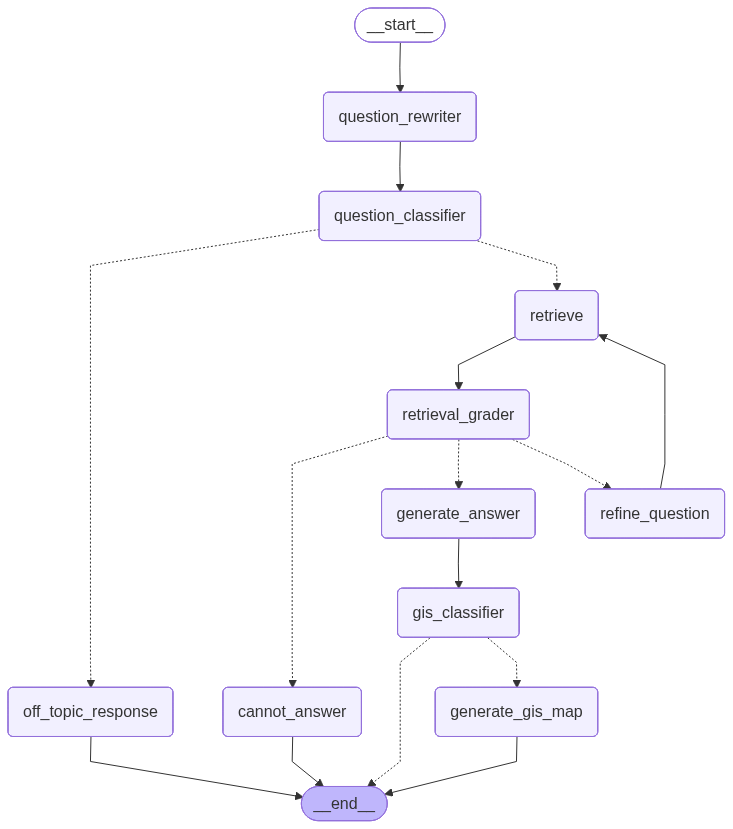

In [137]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [138]:

thread_id = "my-ingres-chatbot-session-4"

while True:
    user_query = input("You: ")
    print(f"User query: {user_query}")
    if user_query.lower() in ["exit", "quit", "q","ok"]:
        print("Goodbye!")
        break
    elif user_query.lower() in ["hello", "hi"]:
        print("Chatbot: Hello! How can I assist you with INGRES groundwater data today?")
        continue

    try:
        # Pass the 'configurable' dictionary with the thread_id
        final_state = graph.invoke(
            {"question": HumanMessage(content=user_query)},
            config={"configurable": {"thread_id": thread_id}}
        )
        
        last_message = final_state['messages'][-1]
        print(f"Chatbot: {last_message.content}")
        
        if final_state.get('map_html'):
            print("\n[GIS map generated]\n")
            with open("gis_map.html", "w") as f:
                f.write(final_state['map_html'])
            print("Map saved as gis_map.html. Open it in your browser to view.")

    except Exception as e:
        print(f"An error occurred: {e}")
        break

User query: stages of extraction pune
Entering question_rewriter with following state: {'question': HumanMessage(content='stages of extraction pune', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 5 documents
Entering retrieval_grader
Grading document: Trend Record: Year: 2018 | Sta... Result: yes
Grading document: Trend Record: Year: 2023 | Sta... Result: yes
Grading document: Trend Record: Year: 2016 | Sta... Result: yes


2025-09-07 03:34:58,608 - INFO - Retrieved Documents:
2025-09-07 03:34:58,610 - INFO - Trend Record: Year: 2018 | State: Maharashtra | District: Pune | Annual_Recharge_BCM: 1.872 | Annual_Extraction_BCM: 2.269 | Stage_of_Extraction_Percent: 34.65 | Safe_Units: 16 | Semi_Critical_Units: 10 | Critical_Units: 4 | Over_Exploited_Units: 7 | Average_Water_Level_MBGL: 11.38 | Rainfall_MM: 1198.6
2025-09-07 03:34:58,612 - INFO - Trend Record: Year: 2023 | State: Maharashtra | District: Pune | Annual_Recharge_BCM: 1.01 | Annual_Extraction_BCM: 3.348 | Stage_of_Extraction_Percent: 96.4 | Safe_Units: 23 | Semi_Critical_Units: 5 | Critical_Units: 2 | Over_Exploited_Units: 11 | Average_Water_Level_MBGL: 9.25 | Rainfall_MM: 389.5
2025-09-07 03:34:58,613 - INFO - Trend Record: Year: 2016 | State: Maharashtra | District: Pune | Annual_Recharge_BCM: 6.827 | Annual_Extraction_BCM: 2.951 | Stage_of_Extraction_Percent: 44.53 | Safe_Units: 35 | Semi_Critical_Units: 11 | Critical_Units: 2 | Over_Exploited_U

Grading document: Trend Record: Year: 2017 | Sta... Result: yes
retrieval_grader: proceed_to_generate = True


2025-09-07 03:35:00,938 - INFO - Generated Content: I cannot find information about the "stages of extraction Pune" within the provided context.


Chatbot: I cannot find information about the "stages of extraction Pune" within the provided context.
User query: ok
Goodbye!
